# Theoretical Transition Matrix

Will try to create a transition matrix, under population structure, from theory.

In [2]:
# from abinitio_tm import abinitio 
import numpy as np
from msprime_models import * 
# from abinitio_tm import scaled_time_intervals
# from msprime_utils import scaled_time_intervals, get_het, round_coal_times, tm_counts, get_coal_data, round_bin_coal_data, normalise
from msprime_utils import *
from heatmaps_generate import * 
from vcf_mhs import *
import argparse
from matplotlib.patches import Rectangle
import pdb



# change plot size
plt.rcParams['figure.figsize'] = [12, 8]

In [61]:
def theoretical_matrix(time_array,T_s,T_e,gamma,N,rho=2e-08,mu=2e-08):
    """
    Function to output transition matrix probabilities, under population structure.
    Assume constant population size for now
    time_array: a np array of time points, let's try discreet generations as input ( i.e. [1,2,3,...,200000])
    T_s: start point of structure, in discrete time
    T_e: end point of structure, in discrete time
    gamma: fraction of lineages migrating
    N: population size, in future upgrade to non constant size capability
    """
    
    # convert all times (given in discrete) to continuous
    time_array = time_array/(2*N)
    T_s = T_s/(2*N)
    T_e = T_e/(2*N)
    
    # break down into cases
    
    def lambd(t):
        # return population array size into continuous time
        lambd = 1
        return lambd
    
    def lambd_A(t):
        # return population array size into continuous time
        lambd = 1
        return lambd
    
    def lambd_B(t):
        lambd =1
        # return population array size into continuous time
        return lambd
    
    def L(time1,time2):
        L = np.exp(-(time2 - time1))
        return L
    
    def int_L_c(time2,c):
        if time2<c:
            print('mistake in int_L_c')
        else: 
            intL = 1 - np.exp(-(time2-c))  
        return intL
    
    def int_L_squared_0(t2):
        # integral of L(time1, time2)^2 from 0 to time2
        intL = 0.5 * (1-np.exp(-2*t2))
        return intL
    
    def int_L_squared_c(time2,c):
        # integral of L(time1,time2)^2 from c to time2
        if c>time2:
            print('mistake in int_L_squared_c')
        else:
            intL = 0.5 * (1-np.exp(-2*(time2-c)))
        return intL
        
    # Case 1, 2 and 3,
    def Case123(Q,t,s):
        q = (1-np.exp(-2*rho*s))*(1/s)*lambd(t)*int_L_squared_0(t)
        return q
        
    def Case4(Q,t,s):
    # Case 4
    
        prob_a = ((1-gamma)**2)/( ((1-gamma)**2)+gamma**2 ) # probability of case a)
        prob_b = ((gamma)**2)/( ((1-gamma)**2)+gamma**2 ) # probability of case b)
        q = (1-np.exp(-2*rho*s))*(1/s)*(
            prob_a*lambd_A(t)*( int_L_squared_0(T_s)*(1-gamma)*(L(T_s,t)**2) + int_L_squared_c(t,T_s) )+
            prob_b*lambd_B(t)*( int_L_squared_0(T_s)*(gamma)*(L(T_s,t)**2) + int_L_squared_c(t,T_s) ) 
            )
        return q
    
    def Case5(Q,t,s):
        q = Case4(Q,t,s) # Case 5 is the same as Case 4, I think
        return q
    
    def Case6(Q,t,s):
        prob_a = ((1-gamma)**2)
        prob_b = ((gamma)**2)
        prob_c = 2*gamma*(1-gamma)
        q = (1-np.exp(-2*rho*s))*(1/s)*lambd(t)*(
            prob_a*( int_L_squared_0(T_s)*(1-gamma)*(L(T_s,T_e)**2)*(L(T_e,t)**2) + int_L_squared_c(T_e,T_s)*(L(T_e,t)**2) + 
                    int_L_squared_c(t,T_e)) +
            prob_b*( int_L_squared_0(T_s)*(gamma)*(L(T_s,T_e)**2)*(L(T_e,t)**2) + int_L_squared_c(T_e,T_s)*(L(T_e,t)**2) +
                    int_L_squared_c(t,T_e)) +
            prob_c*( (L(T_e,t)**2)*int_L_squared_0(T_s)*( (1-gamma)*L(T_s,T_e) + gamma*(L(T_s,T_e)) )
                    + (L(T_e,t)**2)*0.5*( int_L_c(T_e,T_s) + int_L_c(T_e,T_s) ) + int_L_squared_c(t,T_e))    
        )
        return q
    
    
     # initialise Q, which is whole transition matrix
    Q = np.zeros(shape=(len(time_array),len(time_array)))

    # write values of Q, on Case by Case basis
    for i in range(0,len(time_array)):
        t = time_array[i]
        for j in range(i+1,len(time_array)):
            s = time_array[j]
#             print(f'i is {i}, j is {j}, t is {t}, s is {s}, T_s is {T_s}, T_e is {T_e}')
            if (t < T_s and s < T_s) or (t < T_s and T_s <= s < T_e) or (t < T_s and s >= T_e):
                Q[i,j] = Case123(Q,t,s)
            elif (t>=T_s and t<T_e) and (s>=T_s and s<T_e):
                Q[i,j] = Case4(Q,t,s)
            elif (t>=T_s and t<T_e) and (s>=T_e):
                Q[i,j] = Case5(Q,t,s)
            elif (t>=T_e) and (s>=T_e):
                Q[i,j] = Case6(Q,t,s)
            else: 
                print('problem in assigning case')
    
    print('success, returning Q')
    return Q

In [62]:
# parameters
T_s = 20000 # start of structure
T_e = 40000 # end of structure
N = 10000 # diploid population size
gamma = 0.2 # percentage of lineages splitting at T_s

# time_array TODO make this logarithmic
max_time = 200000 # max time in time_array
resolution = 200 #  resolution of transitio matrix, how many time intervals are wanted  
time_array = np.arange(0,max_time,max_time/resolution)


In [63]:
Q = theoretical_matrix(time_array,T_s,T_e,gamma,N,rho=2e-08,mu=2e-08)

success, returning Q


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


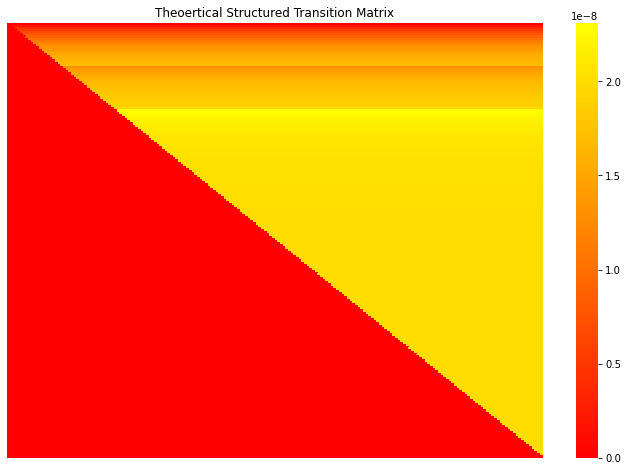

In [64]:
heatmaps_seq(Q,title='Theoertical Structured Transition Matrix') # show heatmap
# think this might be ok!